4819
1796 loop inducing obstacles


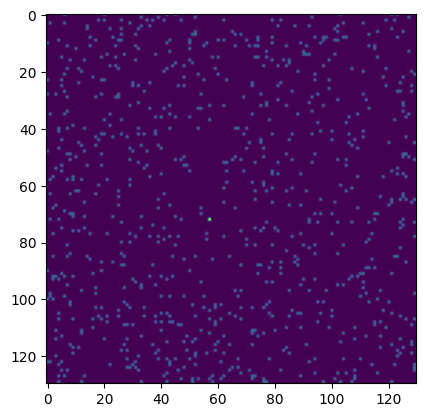

In [72]:

import numpy as np

class GuardMap():
    move_map = {
        3: lambda r, c: (r - 1, c), # up
        4: lambda r, c: (r, c+1), # right
        5: lambda r, c: (r+1, c), # down
        6: lambda r, c: (r, c-1) # left
    }

    def __init__(self, text_map):
        # "." becomes 0, "#" becomes 1, and ^>v< becomes 3, 4, 5, 6 (numpad)
        self.guard_map = [[0 if c == '.' else 1 if c == '#' else 3 if c == '^' else c for c in row] for row in text_map]
        self.guard_map = np.array(self.guard_map)

    def simulate_guard_traversal(self):
        start = self.find_guard()
        moves = self.move(start)
        print(len(set(moves)))

    def simulate_guard_loop(self):
        # we want to all the places we can place an obstacle that will force the guard to loop
        # first we find the path the guard takes
        start = self.find_guard()
        moves = self.move(start)

        # next we find where all the obstacles are
        obstacles = np.where(self.guard_map == 1)
        obstacles = [(int(a), int(b)) for a, b in list(zip(obstacles[0], obstacles[1]))] # as int tuples

        # get all lines that are left of each obstacle
        o_left = list(set([c-1 for _, c in obstacles if c > 0]))
        o_below = list(set([r+1 for r, _ in obstacles if r < self.guard_map.shape[0]-1]))

        # we have reduced our search area
        # an obstacle in the overlap of moves and (o_left or o_below) can force the guard to loop
        # obstacles outside of this will never force the guard to loop
        o_places = [m for m in moves if m != start and (m[0] in o_left or m[1] in o_below)]

        # we can now brute force the placement of obstacles
        loop_inducing_obstacles = []
        for i, o in enumerate(o_places):
            self.guard_map[o] = 1
            start = self.find_guard()
            is_loop, moves = self.move(start, loop_detection=True)
            if is_loop:
                loop_inducing_obstacles.append(o)
            
            print(f"Progress: {i / len(o_places) * 100:.2f}%", end='\r')
            self.guard_map[o] = 0

        # deduplicate 
        loop_inducing_obstacles = list(set(loop_inducing_obstacles))
        print(f"{len(loop_inducing_obstacles)} loop inducing obstacles")
        
    def find_guard(self):
        loc = np.where(self.guard_map == 3)
        return (int(loc[0][0]), int(loc[1][0]))
    
    def move(self, loc, loop_detection=False):
        moves = [loc]
        direction = self.guard_map[loc]
        while True:
            new_loc = self.move_map[direction](*loc)
            if self.out_of_bounds(new_loc):
                if loop_detection:
                    return (False, moves)
                return moves
            elif self.guard_map[new_loc] == 1:
                direction = (direction-3+1) % 4 + 3
            else:
                # check for loops
                if new_loc in moves:
                    # get the last index of new_loc in moves
                    loop_start = abs(moves[::-1].index(new_loc)-len(moves))-1
                    if loop_start > 0 and loop_start < len(moves) and moves[loop_start-1] == loc:
                        moves.append(new_loc)
                        if loop_detection:
                            return (True, moves)
                        return moves

                loc = new_loc              
                moves.append(loc)

    def out_of_bounds(self, loc):
        return loc[0] < 0 or loc[0] >= self.guard_map.shape[0] or loc[1] < 0 or loc[1] >= self.guard_map.shape[1]
    
    def __str__(self):
        acc = ''
        for row in self.guard_map:
            acc += ''.join(str(c) for c in row) + '\n'
        return acc


import matplotlib.pyplot as plt
with open('input.txt') as f:
    guard_map = [l.strip() for l in f.readlines()]

gm = GuardMap(guard_map)

plt.color_sequences = ['white', 'black', 'red', 'blue', 'green', 'yellow']
plt.imshow(gm.guard_map)

gm.simulate_guard_traversal()

gm.simulate_guard_loop()

plt.show()